<a href="https://colab.research.google.com/github/KJM94/pyd/blob/main/ch6_4_improve_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- one shot running
- few shot running

In [ ]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

train_X = train_X / 255.0
test_X = test_X / 255.0

# reshape 이전
print(train_X.shape, test_X.shape)

train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

# reshape 이후
print(train_X.shape, test_X.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


### (2) 모형 정의

이번에는 모형 정의를 진행합니다. 코드가 길어질 수 있으니 주의하기 바랍니다. 


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=32, padding='same', activation='relu'), 
  tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)), 
  tf.keras.layers.Dropout(rate=0.5), 
  tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),    
  tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),  
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(units=512, activation='relu'), 
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(units=10, activation='softmax')                           
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0

`VGGNet`은 여러 개의 구조로 실험했는데 그 중 19개의 레이어가 겹쳐진 `VGG-19`가 제일 깊은 구조입니다. `VGG-19`는 특징 추출기의 초반에 컨볼루션 레이어를 2개 겹친 뒤 풀링 레이어 1개를 사용하는 패턴을 2차례, 그 후 컨볼루션 레이어를 4개 겹친 뒤 풀링 레이어 1개를 사용하는 패턴을 3차례 반복합니다. 

그러나, 이 역시 대상 이미지의 크기 등에 따라 달라집니다. 

여기에서는 컨볼루션 레이어를 2개 겹치고 풀링 레이어를 1개 사용하는 패턴을 2차례 반복합니다. 풀링 레이어 다음에 드롭아웃 레이러를 위치시켜서 과적합을 방지합니다. 또한, Flatten 레이어 다음에 이어지는 3개의 Dense 레이어 사이에도 드롭아웃 레이어를 배치합니다. 컨볼루션 레이어와 Dense 레이어의 개수만 세면 `VGG-7`레이어가 됩니다. 

오리지널 `VGG-19`보다는 깊이가 얕지만 총 파라미터 개수는 약 `520만개`로 적지 않습니다. (ch6_3. 24만개)

### (3) 모형 성능 확인
이 모델의 성능을 확인해봅니다. (이 때, 런타임 유형을 GPU로 변경 하는 것을 잊으면 안됩니다.)


In [ ]:
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

Epoch 1/25
1407/1407 [==============================] - 11s 8ms/step - loss: 0.5771 - accuracy: 0.7900 - val_loss: 0.3363 - val_accuracy: 0.8774
Epoch 2/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.3704 - accuracy: 0.8655 - val_loss: 0.2815 - val_accuracy: 0.8927
Epoch 3/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.3278 - accuracy: 0.8827 - val_loss: 0.2597 - val_accuracy: 0.9030
Epoch 4/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.3008 - accuracy: 0.8915 - val_loss: 0.2387 - val_accuracy: 0.9125
Epoch 5/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.2899 - accuracy: 0.8961 - val_loss: 0.2286 - val_accuracy: 0.9158
Epoch 6/25
1407/1407 [==============================] - 11s 8ms/step - loss: 0.2765 - accuracy: 0.8999 - val_loss: 0.2228 - val_accuracy: 0.9169
Epoch 7/25
1407/1407 [==============================] - 11s 7ms/step - loss: 0.2689 - accuracy: 0.9037 - val_loss: 0.2264 - val_ac

학습한 모형을 시각화로 다시 확인합니다. 

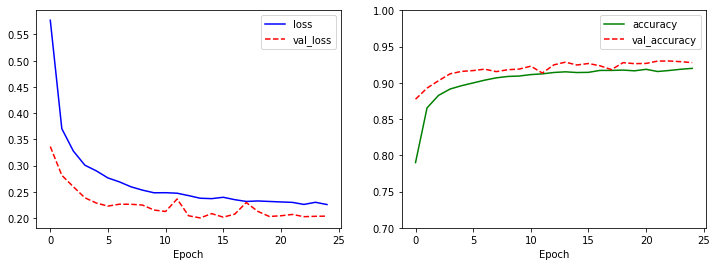

[0.21900136768817902, 0.92330002784729]

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

`var_loss`가 잘 증가하지 않는 드디어 괜찮은 모형을 얻었습니다. 또한 테스트 데이터에 대한 분류 성적도 `91.69%`로 비교적 높은 성과를 거뒀습니다. 이렇게 네트워크 구조 변경만으로도 성능이 향상 된 것을 확인할 수 있습니다. 

## IV. 이미지 보강
이미지 보강은 훈련데이터에 없는 이미지를 새롭게 만들어내서 훈련데이터를 보강하는 기법을 말합니다. `Tensorflow`에는 이미지 보강 작업을 쉽게 해주는 `ImageDataGenerator`가 있습니다. 이를 활용해서 훈련 데이터의 첫 번째 이미지를 변형시킵니다. 

그리고 100개의 변형된 이미지를 그래프로 작성합니다. 

### (1) 이미지 보강의 예


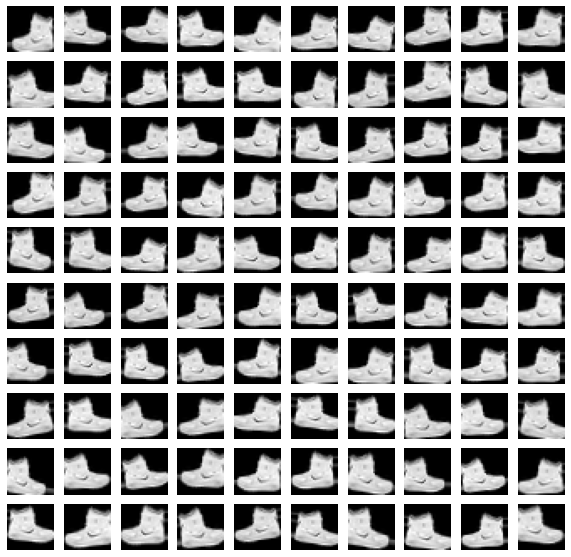

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

image_generator = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.10, 
    shear_range=0.5, 
    width_shift_range=0.10, 
    height_shift_range=0.10, 
    horizontal_flip=True,
    vertical_flip=False)

augment_size = 100

x_augmented = image_generator.flow(np.tile(train_X[0].reshape(28*28), 100).reshape(-1, 28, 28, 1), 
                                   np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

# 새롭게 생성된 이미지 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for c in range(100):
  plt.subplot(10, 10, c+1)
  plt.axis('off')
  plt.imshow(x_augmented[c].reshape(28, 28), cmap='gray')

plt.show()

`ImageDataGenerator`의 주요 인수들에 구체적인 설명은 `교재 169페이지`를 참고하시기를 바랍니다. 또는 한글 번역문서가 있으니 해당 문서에서 추가적인 공부를 진행하기를 바랍니다. [(ImageDataGenerator 클래스)](https://keras.io/ko/preprocessing/image/)


## (2) 3만개 이미지 보강

그러면 실제로 이미지를 보강하고 모형 학습에 추가하는 예제를 진행합니다. 전체적인 모형 학습 코드는 크게 달라지지 않으니, 기 진행했던 내용을 그대로 참조합니다. 

In [ ]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

train_X = train_X / 255.0
test_X = test_X / 255.0

# reshape 이전
print(train_X.shape, test_X.shape)

train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

# reshape 이후
print(train_X.shape, test_X.shape)

image_generator = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.10, 
    shear_range=0.5, 
    width_shift_range=0.10, 
    height_shift_range=0.10, 
    horizontal_flip=True,
    vertical_flip=False)

augment_size = 30000

randidx = np.random.randint(train_X.shape[0], size=augment_size)
x_augmented = train_X[randidx].copy()
y_augmented = train_Y[randidx].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

# 원래 데이터인 x_train에 이미지 보강된 x_augmented를 추가합니다. 
train_X = np.concatenate((train_X, x_augmented))
train_Y = np.concatenate((train_Y, y_augmented))

print(train_X.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)
(90000, 28, 28, 1)


- 훈련 데이터의 50%인 30,000개의 이미지를 추가하기 위해 `augment_size=30000`으로 설정합니다. 
- 이미지를 변형할 원본 이미지를 찾기 위해 `np.random.randint()`함수를 활용하여 0~59,999 범위의 정수 중에서 30,000개의 정수를 뽑았습니다. 이 때 정수는 중복 가능합니다. 
  + 만약, 중복을 원치 않으면, `np.random.ranint()` 대신에 `np.random.choice()` 함수를 사용하고 `replace` 인수를 `False`로 설정합니다. 
- `copy()` 함수를 사용하여 원본은 보전합니다. 
- `image_generator.flow()` 함수를 사용하여 30,000개의 새로운 이미지를 생성했습니다. 
- `np.concatenate()` 함수를 사용하여 훈련 데이터에 보강 이미지를 추가합니다. 그러면, 이미지 보강이 완료가 된 것입니다. 

### (3) 모형 정의

이제 보강된 훈련데이터를 `VGGNet` 스타일의 네트워크에 추가하도록 합니다. 


Epoch 1/25
2110/2110 [==============================] - 16s 8ms/step - loss: 0.5680 - accuracy: 0.7916 - val_loss: 0.6081 - val_accuracy: 0.7691
Epoch 2/25
2110/2110 [==============================] - 16s 7ms/step - loss: 0.3741 - accuracy: 0.8641 - val_loss: 0.4937 - val_accuracy: 0.8155
Epoch 3/25
2110/2110 [==============================] - 16s 7ms/step - loss: 0.3361 - accuracy: 0.8795 - val_loss: 0.4563 - val_accuracy: 0.8346
Epoch 4/25
2110/2110 [==============================] - 16s 7ms/step - loss: 0.3172 - accuracy: 0.8872 - val_loss: 0.4321 - val_accuracy: 0.8388
Epoch 5/25
2110/2110 [==============================] - 16s 7ms/step - loss: 0.3000 - accuracy: 0.8916 - val_loss: 0.4452 - val_accuracy: 0.8407
Epoch 6/25
2110/2110 [==============================] - 16s 7ms/step - loss: 0.2933 - accuracy: 0.8961 - val_loss: 0.4001 - val_accuracy: 0.8527
Epoch 7/25
2110/2110 [==============================] - 16s 7ms/step - loss: 0.2858 - accuracy: 0.8968 - val_loss: 0.4068 - val_ac

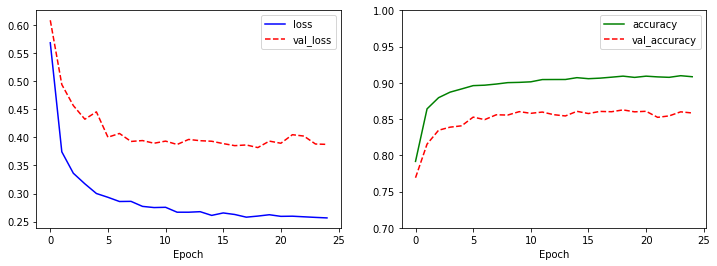

[0.22846069931983948, 0.9157999753952026]

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=32, padding='same', activation='relu'), 
  tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)), 
  tf.keras.layers.Dropout(rate=0.5), 
  tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),    
  tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),  
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(units=512, activation='relu'), 
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(units=10, activation='softmax')                           
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# model.summary()
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

소스코드는 기존에 했던 코드와 차이가 없기 때문에, 코드에 대한 설명은 생략합니다. 그래프 역시, 안정적인 것으로 봐서는 과적합은 일어나지 않았습니다. 그리고, 결과 역시 기존 분류 성적 `91.69%`보다는 성능이 향상된 `92.51%`값을 얻었습니다. 

이렇게 해서 더 많은 레이어를 쌓는 것과 이미지 보강 기법을 통해서 모형을 성능시키는 것까지 배웠습니다. 

## V. 결론

이번장에서는 가장 중요한 개념은 컨볼루션 레이어의 개념, 풀링 레이어의 개념, 그리고 드롭아웃 레이어의 개념입니다. 각각의 역할은 조금씩 상이하다는 것을 꼭 기억하기를 바랍니다. 

## VI. 연습 파일
- [구글 Colab에서 직접 연습해보자](https://colab.research.google.com/github/chloevan/deeplearningAI/blob/master/tensorflow2.0/ch6_4_improve_performance.ipynb) 

## VII. Reference

김환희. (2020). 시작하세요! 텐서플로 2.0 프로그래밍: 기초 이론부터 실전 예제까지 한번에 끝내는 머신러닝, 딥러닝 핵심 가이드. 서울: 위키북스.

[^2]: https://github.com/zalandoresearch/fashion-mnist#benchmark 파이썬 실력이 되시는 분들은 95%이상의 성능을 보유한 Repo에 있는 코드를 직접 가져와 응용하는 것도 큰 도움이 될 수 있습니다. 